In [1]:
cd ../TileEM/

/srv/data/home/jlee782/crowd-seg/analysis/TileEM


In [2]:
%pylab inline
%load_ext autoreload
%autoreload 2
from paper_visualizations import * 
from PixelEM import * 
from test_sample import test_sample_obj
import json
import pandas as pd

Populating the interactive namespace from numpy and matplotlib


In [3]:
# df = pd.read_csv("all_info.csv",index_col=0)
df_object_batch = pd.read_csv("all_object_batch_info.csv",index_col=0)
df_worker = pd.read_csv("all_worker_response_info.csv",index_col=0)
df_object = pd.read_csv("all_object_info.csv",index_col=0)
df_tile = pd.read_csv("all_tile_info.csv",index_col=0)
df_worker_tile = pd.read_csv("all_worker_tile_info.csv",index_col=0)
df_tile["gt overlap norm tarea"]=df_tile["gt overlap area"]/df_tile["tile area"]
df = df_worker.merge(df_tile)

# Tile overlap distribution analysis

In [5]:
def plot_tile_overlap_distribution(batch,objid,small_tiles=True):
    df_tile_subset = df_tile[(df_tile["batch"]==batch)&(df_tile["objid"]==objid)]
    avrg_tarea = df_tile_subset["tile area"].mean()
    if small_tiles: df_tile_subset = df_tile_subset[df_tile_subset["tile area"]<avrg_tarea]
    ydata  = df_tile_subset["tile area"]-df_tile_subset["gt overlap area"]
    xdata  = df_tile_subset["gt overlap area"]
    fig = plt.figure()
    ax = fig.add_subplot(111)
    plt.title("{}; obj{}".format(batch,objid))
    if small_tiles: plt.title("{}; obj{} [small tiles only]".format(batch,objid))
    plt.scatter(xdata,ydata,marker='.',label="Tile")
    partial_frac = len(np.where((xdata!=0)&(ydata!=0))[0])/float(len(ydata))*100
    plt.text(0.87, 0.75,"Partial:{:.2f}%".format(partial_frac),horizontalalignment='center',verticalalignment='center',transform = ax.transAxes)
    plt.text(0.85, 0.70,"Area Cutoff:{:.2f}".format(avrg_tarea),horizontalalignment='center',verticalalignment='center',transform = ax.transAxes)
    plt.text(0.87, 0.65,"Total Tiles:{}".format(len(ydata)),horizontalalignment='center',verticalalignment='center',transform = ax.transAxes)
    x = np.linspace(0,xdata.max())
    def f(x,alpha=1.):
        return alpha*x
    plt.plot(x,f(x),'--',color='red',label="y=x")
    #plt.plot(x,f(x,0.2),'--',color='green',label="y=0.2x")
    # plt.plot(x,f(x,1.2),'--',color='green',label="y=1.2x")
    plt.legend(loc='upper right')
    plt.xlabel("Intersection area",fontsize=13)
    plt.ylabel("Outside area",fontsize=13)

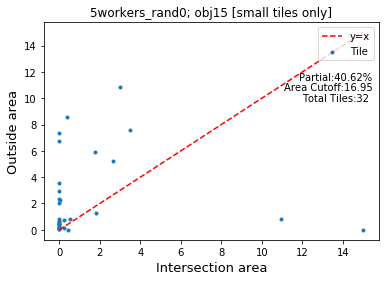

In [10]:
plot_tile_overlap_distribution( '5workers_rand0',15)

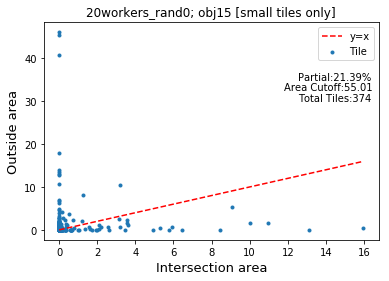

In [11]:
plot_tile_overlap_distribution('20workers_rand0',15)

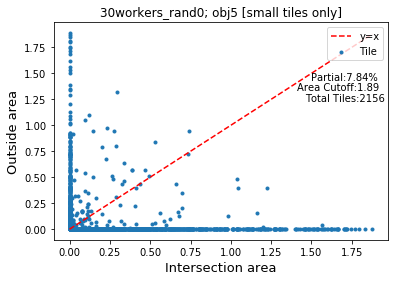

In [12]:
plot_tile_overlap_distribution('30workers_rand0',5)

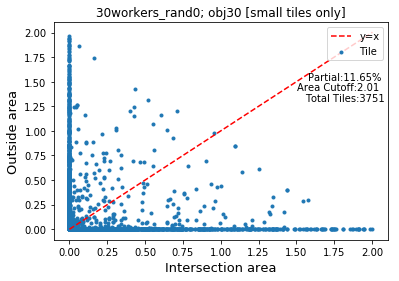

In [13]:
plot_tile_overlap_distribution('30workers_rand0',30)

- [*]compare with where MV does wrong 

# Worker Quality 

we only show this for tiles that are highly voted by many workers 

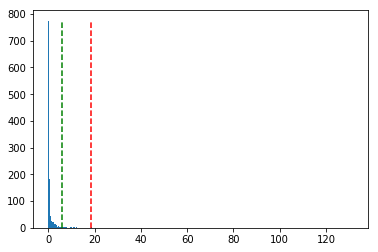

In [99]:
a = plt.hist(tile_area,bins=500)
plt.vlines(np.percentile(tile_area,95),0,a[0].max(),linestyles='--',colors='green')
plt.vlines(np.percentile(tile_area,99),0,a[0].max(),linestyles='--',colors='red')

In [4]:
def plot_overlap_vs_worker_quality(batch,objid,y_attr,split=[0.7,0.85],delta=0.03):
    bin2size={0:'small',1:'medium',2:'large'}
    df_tile_subset = df[(df["batch"]==batch)&(df["objid"]==objid)]
    if len(df_tile_subset)==0: return
    df_worker_tile_subset = df_worker_tile[(df_worker_tile["batch"]==batch)&(df_worker_tile["objid"]==objid)]
    tile_lst = np.array(list(set(df_tile_subset["tile id"])))
    tile_area = list(set(df_tile_subset["tile area"]))
    bin_edges = [np.percentile(tile_area,95),np.percentile(tile_area,99)]
    bin_idx = np.digitize(tile_area,bin_edges)
    for size in list(set(bin_idx)):
        fig,(ax,ax2) = plt.subplots(1, 2, sharex=True)
        idx = np.where(bin_idx==size)[0]
        for tidx in tile_lst[idx]:
            yes_workers= df_worker_tile_subset[(df_worker_tile["tile id"]==tidx)]["worker id"].values
            selected = df_tile_subset[(df_tile_subset["tile id"]==tidx)&(df_tile_subset["worker id"].isin(yes_workers))]
            no_selected = df_tile_subset[(df_tile_subset["tile id"]==tidx)&(~df_tile_subset["worker id"].isin(yes_workers))]

            xdata1 = no_selected['gt overlap area']/no_selected['tile area']
            ydata1 = no_selected[y_attr]
            #plt.plot(xdata,ydata,'.',color='red')

            ax.plot(xdata1, ydata1,'.',color='red')
            ax2.plot(xdata1, ydata1,'.',color='red')

            xdata = selected['gt overlap area']/selected['tile area']
            ydata = selected[y_attr]
            #plt.plot(xdata,ydata,'x',color='green')
            ax.plot(xdata, ydata,'x',color='green')
            ax2.plot(xdata, ydata,'x',color='green')

            ymin,ymax= ax.get_ylim()
            ax.set_ylim(min(ydata1)-delta,split[0]) # Definition of bad workers
            ax2.set_ylim(split[1],max(ydata1)+delta)# Definition of good workers
        plt.legend(['unvoted','voted'],bbox_to_anchor=(1.7,1), loc="upper right",fontsize=12)
        fig.text(0.5, 1,"{}; obj{} [{}]".format(batch,objid,bin2size[size]), ha='center',fontsize=14)
        fig.text(0.5, 0, 'overlap fraction', ha='center',fontsize=13)
        fig.text(0.0, 0.5,y_attr, va='center', rotation='vertical',fontsize=13)

        plt.xlim(-0.1,1.1)

        plt.tight_layout()

In [14]:
yes_workers

array([52])

In [17]:
len(selected)

1

In [16]:
len(no_selected)

29

In [20]:

len(df_tile_subset[(df_tile_subset["tile id"]==tidx)])

30

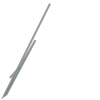

In [26]:
tiles[tidx]

In [29]:
tile_lst[idx]

array([141, 178])

In [31]:
tiles[141].area

2.6628612475789737

In [32]:
tiles[178].area

5.80357142857185

In [28]:
np.array(tile_area)[idx]

array([ 6716.97985772,  1855.77924997])

In [33]:
tile_lst = np.array(list(set(df_tile_subset["tile id"])))
tile_area = list(set(df_tile_subset["tile area"]))

In [35]:
size

2

In [34]:
tile_lst[idx]

array([141, 178])

In [20]:
batch = '5workers_rand0'
objid = 37
tiles = pkl.load(open("uniqueTiles/{}/vtiles{}.pkl".format(batch,objid)))

In [58]:
########################
batch = '5workers_rand0'
objid = 37
y_attr = 'J [GT]'
split=[0.7,0.85]
delta=0.03
########################
bin2size={0:'small',1:'medium',2:'large'}
df_subset = df[(df["batch"]==batch)&(df["objid"]==objid)]
df_tile_subset = df_tile[(df_tile["batch"]==batch)&(df_tile["objid"]==objid)]
# if len(df_tile_subset)==0: return
df_worker_tile_subset = df_worker_tile[(df_worker_tile["batch"]==batch)&(df_worker_tile["objid"]==objid)]
tile_lst = np.array(df_tile_subset["tile id"])
tile_area = np.array(df_tile_subset["tile area"])
bin_edges = [np.percentile(tile_area,95),np.percentile(tile_area,99)]
bin_idx = np.digitize(tile_area,bin_edges)

In [73]:
size = 0
idx = np.where(bin_idx==size)[0]

In [70]:
[tiles[i].area for i in idx]

[6716.979857719588, 1855.7792499709826]

In [72]:
[tiles[i].area for i in idx]

[121.33206058573687,
 1747.9395592499166,
 193.44525406674543,
 69.27182354085187,
 60.23600784045069,
 91.46949300699296,
 175.08150982441057,
 60.590213428605445]

In [74]:
[tiles[i].area for i in idx]

[2.5043103448276156,
 2.363366640319808,
 0.27040816326542505,
 0.06666666666666288,
 0.7112068965517935,
 2.0612745098037397,
 2.740056818181662,
 1.6875000000001112,
 0.5833333333333002,
 24.57575757575779,
 28.724901250822967,
 11.875,
 1.054435483870943,
 8.207805907172945,
 1.9789757020226038,
 0.35074626865679415,
 1.2515262515266352,
 13.754401942926506,
 3.600000000000307,
 0.3092105263157806,
 22.487179487179244,
 21.87380952380963,
 23.667416710273685,
 0.0018140589571094545,
 1.7360108092996094,
 10.670770336510742,
 0.02807881773400489,
 6.75,
 0.08064516129030608,
 4.240783410138363,
 0.703125,
 13.340744947671652,
 1.6623376623377077,
 0.4500000000003155,
 0.14999999999999147,
 1.6857142857143426,
 0.09999999999999432,
 1.5051353874884699,
 31.606875361480558,
 0.2451923076923097,
 0.24135211267608342,
 4.212667383611987,
 10.997029810298123,
 5.597897859615146,
 13.599816849816712,
 22.96678571428577,
 3.520833333333318,
 0.011797385621015621,
 0.1483442008934164,
 23.74

In [7]:
selected["gt overlap norm tarea"]

5392951    1
5448565    1
5652483    1
Name: gt overlap norm tarea, dtype: float64

In [17]:
print xdata1, ydata1
print '-------------'
print xdata, ydata

[ 0.05551919  0.05551919  0.05551919  0.05551919  0.05551919  0.05551919
  0.05551919  0.05551919  0.05551919  0.05551919  0.05551919  0.05551919
  0.05551919  0.05551919  0.05551919  0.05551919  0.05551919  0.05551919
  0.05551919  0.05551919  0.05551919  0.05551919  0.05551919  0.05551919
  0.05551919  0.05551919  0.05551919  0.05551919] [ 0.90576221  0.88198742  0.82725069  0.68579472  0.82639466  0.75873718
  0.69842468  0.6135194   0.88975358  0.85853525  0.82554095  0.8424662
  0.71601922  0.71101862  0.89247295  0.72579219  0.80606924  0.84035052
  0.73763013  0.61502991  0.72303236  0.71832143  0.77085928  0.69341764
  0.88396761  0.91444436  0.82601541  0.70842148]
-------------
[ 0.05551919  0.05551919] [ 0.70666078  0.74011781]


In [36]:
idx = np.where(bin_idx==2)[0]

In [37]:
idx

array([  0, 192])

In [40]:
df_worker_tile_subset[(df_worker_tile["tile id"]==0)]

,batch,objid,worker id,tile id
9645,5workers_rand0,37,199,0
9793,5workers_rand0,37,147,0
9922,5workers_rand0,37,135,0
10006,5workers_rand0,37,52,0
10089,5workers_rand0,37,250,0


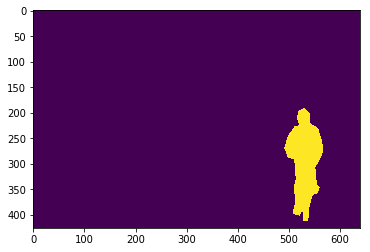

In [51]:
plt.imshow(get_worker_mask(37,140))

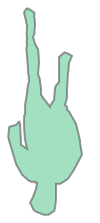

In [49]:
tiles[0]

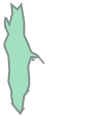

In [48]:
tiles[192]

In [54]:
batch

'5workers_rand0'

In [41]:
df_worker_tile_subset[(df_worker_tile["tile id"]==192)]

,batch,objid,worker id,tile id
9790,5workers_rand0,37,199,192
9921,5workers_rand0,37,147,192
10202,5workers_rand0,37,250,192


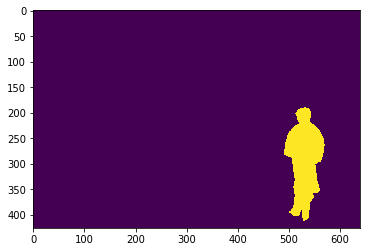

In [45]:
plt.imshow(get_worker_mask(37,199))

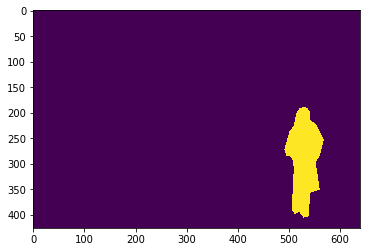

In [46]:
plt.imshow(get_worker_mask(37,147))

In [53]:
df_subset[]

,objid,worker id,Num Points,Area Ratio,P [GT],R [GT],J [GT],TPR [GT],FNR [GT],TNR [GT],FPR [GT],batch,tile id,tile area,gt overlap area,gt overlap norm tarea
5392920,37,135,64,0.026432,0.954244,0.946886,0.905762,0.946886,0.045403,0.998757,0.001243,5workers_rand0,0,6716.979858,6.546281e+03,9.745870e-01
5392921,37,135,64,0.026432,0.954244,0.946886,0.905762,0.946886,0.045403,0.998757,0.001243,5workers_rand0,1,2.504310,0.000000e+00,0.000000e+00
5392922,37,135,64,0.026432,0.954244,0.946886,0.905762,0.946886,0.045403,0.998757,0.001243,5workers_rand0,2,2.363367,0.000000e+00,0.000000e+00
5392923,37,135,64,0.026432,0.954244,0.946886,0.905762,0.946886,0.045403,0.998757,0.001243,5workers_rand0,3,0.270408,2.704082e-01,1.000000e+00
5392924,37,135,64,0.026432,0.954244,0.946886,0.905762,0.946886,0.045403,0.998757,0.001243,5workers_rand0,4,0.066667,6.666667e-02,1.000000e+00
5392925,37,135,64,0.026432,0.954244,0.946886,0.905762,0.946886,0.045403,0.998757,0.001243,5workers_rand0,5,0.711207,7.112069e-01,1.000000e+00
5392926,37,135,64,0.026432,0.954244,0.946886,0.905762,0.946886,0.045403,0.998757,0.001243,5workers_rand0,6,2.061275,1.190476e+00,5.775437e-01
5392927,37,135,64,0.026432,0.954244,0.946886,0.905762,0.946886,0.045403,0.998757,0.001243,5workers_rand0,7,2.740057,1.850099e-01,6.752046e-02
5392928,37,135,64,0.026432,0.954244,0.946886,0.905762,0.946886,0.045403,0.998757,0.001243,5workers_rand0,8,1.687500,1.225379e+00,7.261504e-01
5392929,37,135,64,0.026432,0.954244,0.946886,0.905762,0.946886,0.045403,0.998757,0.001243,5workers_rand0,9,0.583333,1.190476e-02,2.040816e-02


In [68]:
worker_lst = list(set(df_worker_tile_subset["worker id"]))

In [71]:
print worker_lst
print yes_workers

[52, 250, 147, 135, 199]
[199 147 250]


In [60]:
yes_workers= df_worker_tile_subset[(df_worker_tile["tile id"]==tidx)]["worker id"].values

In [72]:
yes_workers= df_worker_tile_subset[(df_worker_tile["tile id"]==tidx)]["worker id"].values
no_workers =[w for w in worker_lst if w not in yes_workers]
selected = df_subset[(df_subset["tile id"]==tidx)&(df_subset["worker id"].isin(yes_workers))]
no_selected = df_subset[(df_subset["tile id"]==tidx)&(df_subset["worker id"].isin(no_workers))]

In [74]:
selected

,objid,worker id,Num Points,Area Ratio,P [GT],R [GT],J [GT],TPR [GT],FNR [GT],TNR [GT],FPR [GT],batch,tile id,tile area,gt overlap area,gt overlap norm tarea
5448726,37,147,25,0.035318,0.726358,0.963043,0.706661,0.963043,0.362809,0.990071,0.009929,5workers_rand0,192,1855.77925,103.031359,0.055519
5652644,37,250,46,0.035099,0.748116,0.985761,0.740118,0.985761,0.331898,0.990917,0.009083,5workers_rand0,192,1855.77925,103.031359,0.055519


In [73]:
no_selected

,objid,worker id,Num Points,Area Ratio,P [GT],R [GT],J [GT],TPR [GT],FNR [GT],TNR [GT],FPR [GT],batch,tile id,tile area,gt overlap area,gt overlap norm tarea
5393112,37,135,64,0.026432,0.954244,0.946886,0.905762,0.946886,0.045403,0.998757,0.001243,5workers_rand0,192,1855.77925,103.031359,0.055519
5402381,37,52,57,0.026638,0.937294,0.937294,0.881987,0.937294,0.062706,0.998284,0.001716,5workers_rand0,192,1855.77925,103.031359,0.055519


In [62]:
yes_workers

array([199, 147, 250])

In [66]:
list(set(selected["worker id"]))

[250, 147]

In [8]:
def plot_overlap_vs_worker_quality(batch,objid,y_attr):
    df_subset = df[(df["batch"]==batch)&(df["objid"]==objid)]
    df_tile_subset = df_tile[(df_tile["batch"]==batch)&(df_tile["objid"]==objid)]
    df_worker_tile_subset = df_worker_tile[(df_worker_tile["batch"]==batch)&(df_worker_tile["objid"]==objid)]
    tile_lst = list(set(df_tile_subset["tile id"]))
    for tidx in tile_lst:
        worker_lst = list(set(df_worker_tile_subset["worker id"]))
        yes_workers= df_worker_tile_subset[(df_worker_tile["tile id"]==tidx)]["worker id"].values
        no_workers =[w for w in worker_lst if w not in yes_workers]
        selected = df_subset[(df_subset["tile id"]==tidx)&(df_subset["worker id"].isin(yes_workers))]
        no_selected = df_subset[(df_subset["tile id"]==tidx)&(df_subset["worker id"].isin(no_workers))]
        
        if len(no_selected)>0:
            xdata = np.array(no_selected["gt overlap norm tarea"])
            ydata = no_selected[y_attr]
            plt.plot(xdata,ydata,'.',color='red')
        if len(selected)>0:
            xdata = np.array(selected["gt overlap norm tarea"])
            ydata = selected[y_attr]
            plt.plot(xdata,ydata,'x',color='green')

    plt.title("{}; obj{}".format(batch,objid))
    plt.xlabel("overlap fraction",fontsize=13)
    plt.ylabel(y_attr,fontsize=13)
    plt.xlim(0,1.1)
    plt.legend(['unvoted','voted'],loc="lower right",fontsize=12)

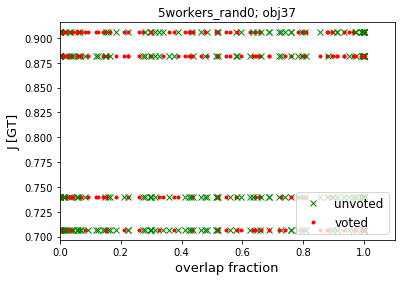

In [9]:
plot_overlap_vs_worker_quality('5workers_rand0',37,'J [GT]')

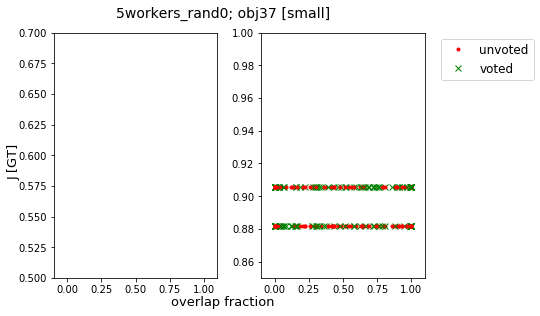

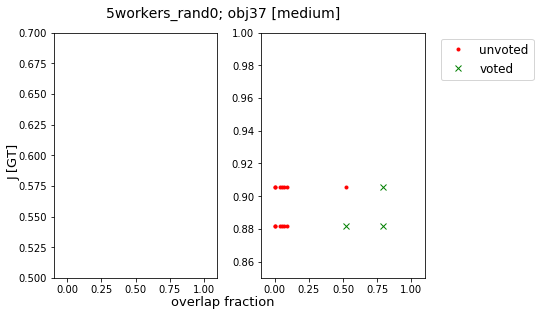

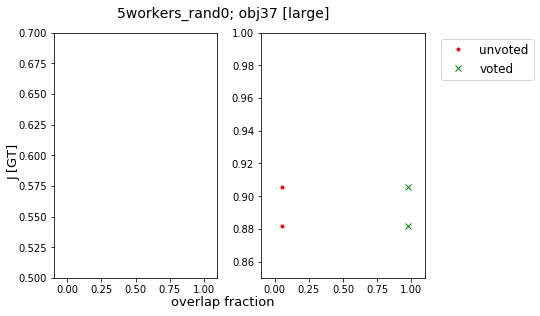

In [20]:
########################
batch = '5workers_rand0'
objid = 37
y_attr = 'J [GT]'
split=[0.7,0.85]
delta=0.03
########################
bin2size={0:'small',1:'medium',2:'large'}
df_subset = df[(df["batch"]==batch)&(df["objid"]==objid)]
df_tile_subset = df_tile[(df_tile["batch"]==batch)&(df_tile["objid"]==objid)]
# if len(df_tile_subset)==0: return
df_worker_tile_subset = df_worker_tile[(df_worker_tile["batch"]==batch)&(df_worker_tile["objid"]==objid)]
tile_lst = np.array(df_tile_subset["tile id"])
tile_area = np.array(df_tile_subset["tile area"])
bin_edges = [np.percentile(tile_area,95),np.percentile(tile_area,99)]
bin_idx = np.digitize(tile_area,bin_edges)
for size in list(set(bin_idx)):
    fig,(ax,ax2) = plt.subplots(1, 2, sharex=True)
    idx = np.where(bin_idx==size)[0]
    if len(idx)!=0:
        for tidx in tile_lst[idx]:
            worker_lst = list(set(df_worker_tile_subset["worker id"]))
            yes_workers= df_worker_tile_subset[(df_worker_tile["tile id"]==tidx)]["worker id"].values
            no_workers =[w for w in worker_lst if w not in yes_workers]
            selected = df_subset[(df_subset["tile id"]==tidx)&(df_subset["worker id"].isin(yes_workers))]
            no_selected = df_subset[(df_subset["tile id"]==tidx)&(df_subset["worker id"].isin(no_workers))]

            xdata1 = np.array(no_selected["gt overlap norm tarea"])
            ydata1 = np.array(no_selected[y_attr])
            #plt.plot(xdata,ydata,'.',color='red')

            ax.plot(xdata1, ydata1,'.',color='red')
            ax2.plot(xdata1, ydata1,'.',color='red')

            xdata = np.array(selected["gt overlap norm tarea"])
            ydata = np.array(selected[y_attr])
#             if len(selected)==0: print tidx
            #plt.plot(xdata,ydata,'x',color='green')
            ax.plot(xdata, ydata,'x',color='green')
            ax2.plot(xdata, ydata,'x',color='green')

            ymin,ymax= ax.get_ylim()
#             yall = concatenate(ydata,ydata1)
            ax.set_ylim(0.5,split[0]) # Definition of bad workers
            ax2.set_ylim(split[1],1)# Definition of good workers
        plt.legend(['unvoted','voted'],bbox_to_anchor=(1.7,1), loc="upper right",fontsize=12)
        fig.text(0.5, 1,"{}; obj{} [{}]".format(batch,objid,bin2size[size]), ha='center',fontsize=14)
        fig.text(0.5, 0, 'overlap fraction', ha='center',fontsize=13)
        fig.text(0.0, 0.5,y_attr, va='center', rotation='vertical',fontsize=13)

        plt.xlim(-0.1,1.1)

        plt.tight_layout()

In [22]:
def plot_overlap_vs_worker_quality(batch,objid,y_attr,split=[0.7,0.85],delta=0.03):
    bin2size={0:'small',1:'medium',2:'large'}
    df_subset = df[(df["batch"]==batch)&(df["objid"]==objid)]
    df_tile_subset = df_tile[(df_tile["batch"]==batch)&(df_tile["objid"]==objid)]
    # if len(df_tile_subset)==0: return
    df_worker_tile_subset = df_worker_tile[(df_worker_tile["batch"]==batch)&(df_worker_tile["objid"]==objid)]
    tile_lst = np.array(df_tile_subset["tile id"])
    tile_area = np.array(df_tile_subset["tile area"])
    bin_edges = [np.percentile(tile_area,95),np.percentile(tile_area,99)]
    bin_idx = np.digitize(tile_area,bin_edges)
    for size in list(set(bin_idx)):
        fig,(ax,ax2) = plt.subplots(1, 2, sharex=True)
        idx = np.where(bin_idx==size)[0]
        if len(idx)!=0:
            for tidx in tile_lst[idx]:
                worker_lst = list(set(df_worker_tile_subset["worker id"]))
                yes_workers= df_worker_tile_subset[(df_worker_tile["tile id"]==tidx)]["worker id"].values
                no_workers =[w for w in worker_lst if w not in yes_workers]
                selected = df_subset[(df_subset["tile id"]==tidx)&(df_subset["worker id"].isin(yes_workers))]
                no_selected = df_subset[(df_subset["tile id"]==tidx)&(df_subset["worker id"].isin(no_workers))]

                xdata1 = np.array(no_selected["gt overlap norm tarea"])
                ydata1 = np.array(no_selected[y_attr])
                #plt.plot(xdata,ydata,'.',color='red')

                ax.plot(xdata1, ydata1,'.',color='red')
                ax2.plot(xdata1, ydata1,'.',color='red')

                xdata = np.array(selected["gt overlap norm tarea"])
                ydata = np.array(selected[y_attr])
    #             if len(selected)==0: print tidx
                #plt.plot(xdata,ydata,'x',color='green')
                ax.plot(xdata, ydata,'x',color='green')
                ax2.plot(xdata, ydata,'x',color='green')

                ymin,ymax= ax.get_ylim()
    #             yall = concatenate(ydata,ydata1)
                ax.set_ylim(0.5,split[0]) # Definition of bad workers
                ax2.set_ylim(split[1],1)# Definition of good workers
            plt.legend(['unvoted','voted'],bbox_to_anchor=(1.7,1), loc="upper right",fontsize=12)
            fig.text(0.5, 1,"{}; obj{} [{}]".format(batch,objid,bin2size[size]), ha='center',fontsize=14)
            fig.text(0.5, 0, 'overlap fraction', ha='center',fontsize=13)
            fig.text(0.0, 0.5,y_attr, va='center', rotation='vertical',fontsize=13)

            plt.xlim(-0.1,1.1)

            plt.tight_layout()

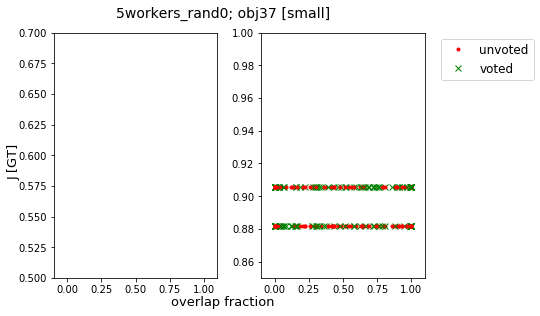

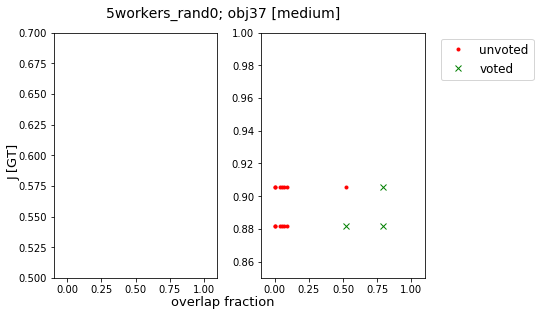

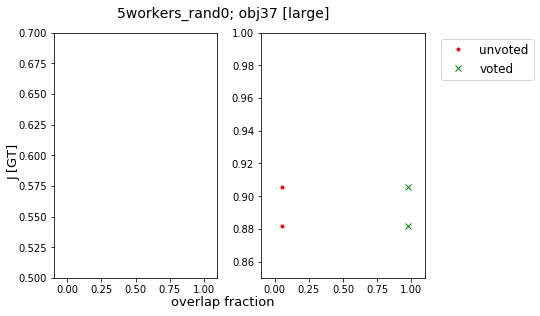

In [23]:
plot_overlap_vs_worker_quality('5workers_rand0',37,'J [GT]')

In [ ]:
plot_overlap_vs_worker_quality('25workers_rand0',37,'J [GT]')

In [ ]:
plot_overlap_vs_worker_quality('25workers_rand0',32,'J [GT]')

In [ ]:
plot_overlap_vs_worker_quality('25workers_rand0',46,'J [GT]')

##### convergence of worker qualities (i.e. picked the same tiles combination) is higher for tiles which are completely inside or outside (i.e. overlap fractions of 0 or 1)

In [ ]:
plot_overlap_vs_worker_quality('5workers_rand0',10,'P [GT]')

In [ ]:
plot_overlap_vs_worker_quality('5workers_rand0',10,'R [GT]')

In [ ]:
plot_overlap_vs_worker_quality('5workers_rand0',10,'J [GT]')

- ~~separate by small tile, medium tile and large tiles~~

- [*] what is the turnover where worker switch from red to green? 

Each vertical line represents a tile. Every horizontal line represents a worker. 

In [10]:
batch = '5workers_rand0'
wid = 196
df_tile["outside area"]=df_tile["tile area"]-df_tile["gt overlap area"]
weighted_qj_tbl = []
for objid in list(set(df_object["objid"])):
    df_tile_subset = df_tile[(df_tile["batch"]==batch)&(df_tile["objid"]==objid)]
    image_area = float(df_object[df_object["objid"]==objid]["Image area"])
    df_worker_tile_subset = df_worker_tile[(df_worker_tile["batch"]==batch)&(df_worker_tile["objid"]==objid)]
    tile_lst = list(set(df_worker_tile_subset["tile id"]))
    for wid in list(set(df_worker_tile_subset["worker id"])):#list(set(df_worker["worker id"])):
        voted_tiles = list(df_worker_tile_subset[df_worker_tile_subset["worker id"]==wid]["tile id"])
        if len(voted_tiles)>0:
            non_voted_tiles =[t for t in tile_lst if t not in voted_tiles]
            voted_area_term = df_tile_subset[df_tile_subset["tile id"].isin(voted_tiles)]["gt overlap area"].sum()
            non_voted_area_term = df_tile_subset[df_tile_subset["tile id"].isin(non_voted_tiles)]["outside area"].sum()
            weighted_qj =(non_voted_area_term+voted_area_term)/image_area
            weighted_qj_tbl.append([wid,weighted_qj])

weighted_qj_tbl = pd.DataFrame(weighted_qj_tbl,columns=["worker id","weighted qj"])

df_worker = df_worker.merge(weighted_qj_tbl)

In [12]:
df = df_worker.merge(df_tile)

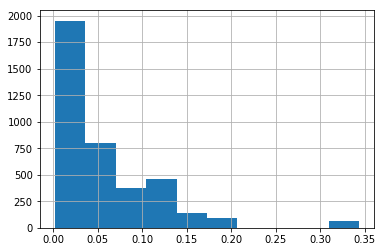

In [16]:
df_worker["weighted qj"].hist()

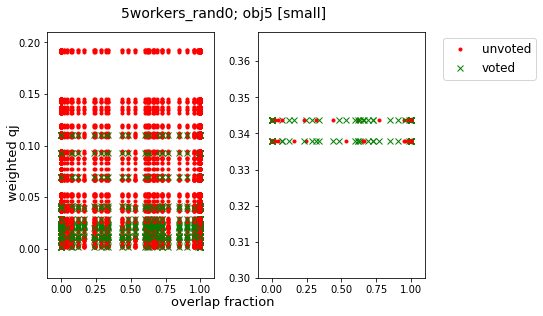

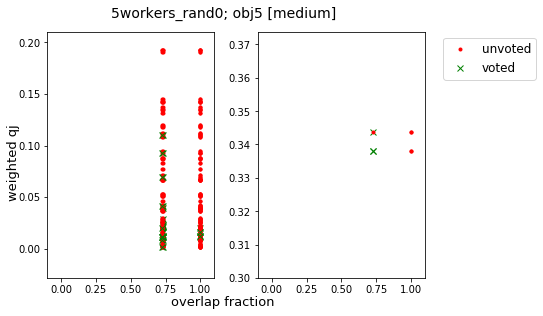

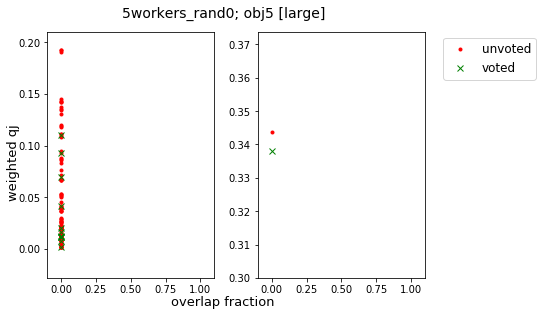

In [17]:
plot_overlap_vs_worker_quality('5workers_rand0',5,"weighted qj",[0.21,0.3])

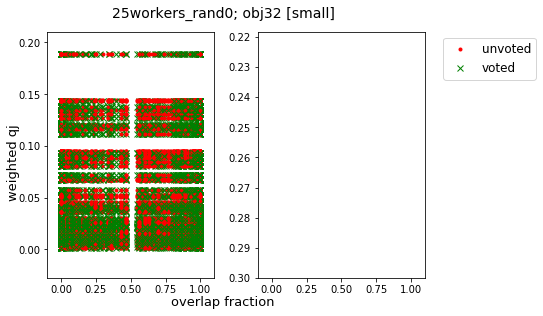

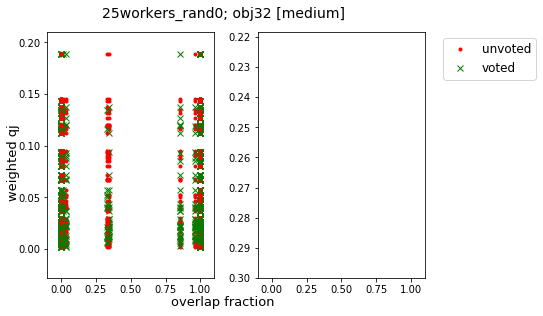

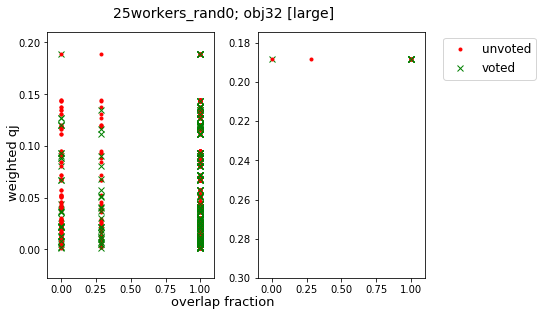

In [19]:
plot_overlap_vs_worker_quality('25workers_rand0',32,"weighted qj",[0.21,0.3])

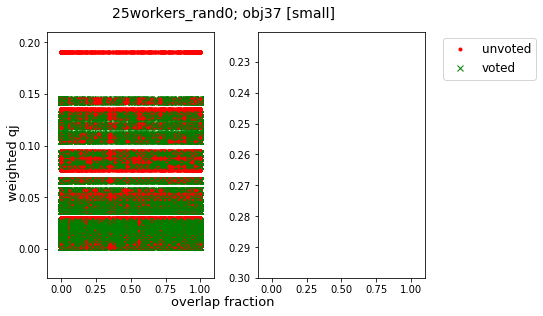

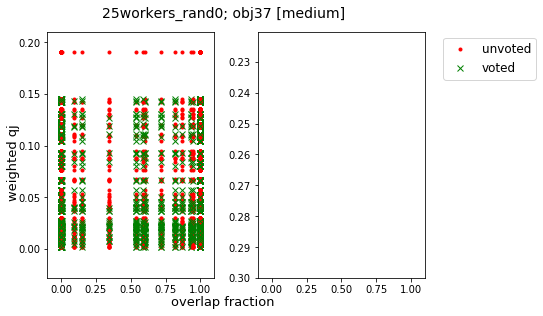

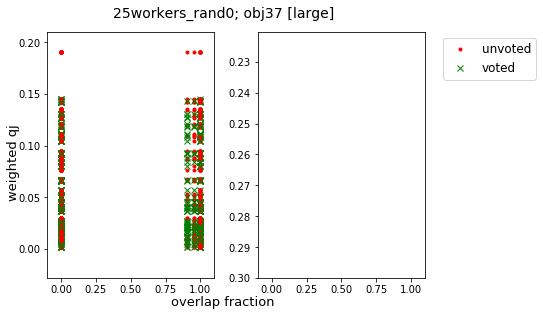

In [20]:
plot_overlap_vs_worker_quality('25workers_rand0',37,"weighted qj",[0.21,0.3])

# Histogram of mistakes: 
- treat if overlap fraction >0.5 then we pick it, what is the accumlated area of mistake (of the external area) that we would make 
- start off by saying that > 0.5 overlap we pick, so "error area" = outside area of the tile, and <= 0.5 overlap we discard the tile in which case "error area" = intersection area.

In [55]:
def plot_mistake_histogram(batch,objid,small_tiles=True):
    df_tile["tile overlap frac"]=df_tile["gt overlap area"]/df_tile["tile area"]
    df_tile["outside area"]=df_tile["tile area"]-df_tile["gt overlap area"]
    df_tile_subset = df_tile[(df_tile["batch"]==batch)&(df_tile["objid"]==objid)]
    tile_lst = np.array(list(set(df_tile_subset["tile id"])))
    # tile_area = list(set(df_tile_subset["tile area"]))
    # tile_outside_area = list(set(df_tile_subset["outside area"]))
    mistake_area = []
    mistake_area_overselect = []
    mistake_area_discard = []
    mistake_count =[]
    for tidx in tile_lst:
        df_selected = df_tile_subset[df_tile_subset["tile id"]==tidx]
        if float(df_selected["tile overlap frac"])>=0.5:
            mistake_area.append(float(df_selected["gt overlap area"]))
            mistake_area_overselect.append(float(df_selected["gt overlap area"]))
            mistake_count.append(float(df_selected["tile area"]))
        else: 
            mistake_area.append(float(df_selected["outside area"]))
            mistake_area_discard.append(float(df_selected["outside area"]))
            mistake_count.append(float(df_selected["tile area"]))
    plt.figure()
    plt.title("Selected Mistake Histogram")
    if small_tiles: 
        a = plt.hist([mistake_area_discard,mistake_area_overselect],range=(0,mean(mistake_area)),bins=30)
    else:
        a = plt.hist([mistake_area_discard,mistake_area_overselect],bins=30)
    plt.legend(['discard','overselect'],fontsize=13)
    plt.xlabel("Tile Area",fontsize=13)
    plt.ylabel("Count",fontsize=13)
    plt.figure()
    plt.title("Total Mistake Histogram")
    if small_tiles: 
        a = plt.hist(mistake_area,range=(0,mean(mistake_area)),bins=30)
    else:
        a = plt.hist(mistake_area,bins=30)
    plt.xlabel("Tile Area",fontsize=13)
    plt.ylabel("Count",fontsize=13)

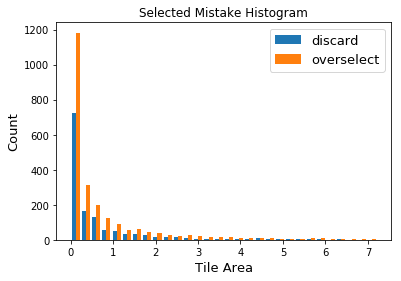

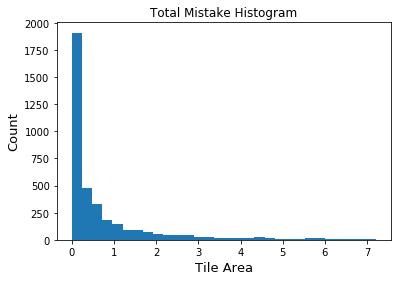

In [56]:
plot_mistake_histogram('30workers_rand0',1)

look at 5 and 10 , less small tiles 

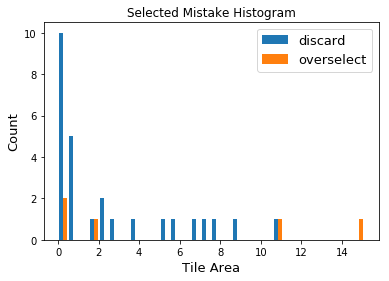

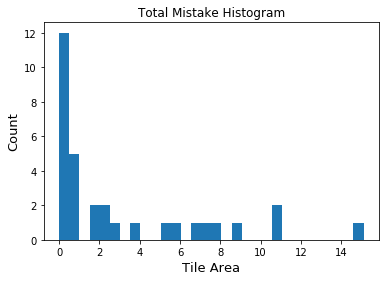

In [54]:
plot_mistake_histogram('5workers_rand0',15)

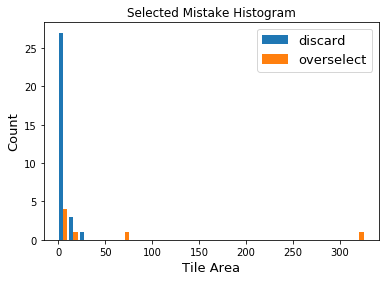

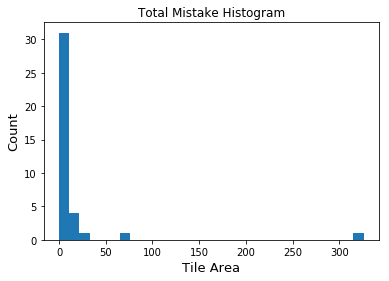

In [57]:
plot_mistake_histogram('5workers_rand0',15,False)

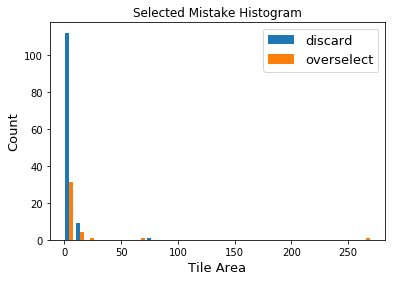

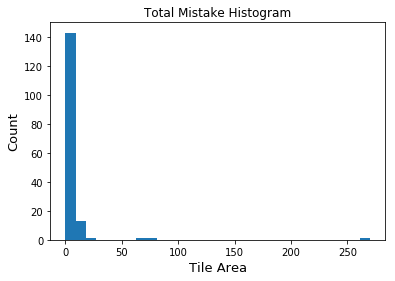

In [59]:
plot_mistake_histogram('10workers_rand0',15,False)